In [1]:
%%html
<style>
table {float:left}
</style>

In this notebook, we used two datasets of pancreatic cells. For gene markers, we used the Panglao Cell Type Marker database.

We used the Baron (2016) dataset for training the neural network (NN) because it has more cells and classes, and we used the Xin (2016) dataset for testing purposes because all of its classes are present in the Baron dataset.

In [2]:
EPOCHS = 50

In [3]:
import Autolib as ali
import Autolib.backend as A
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

SPECIES = 'Human'
DATASET_BARON_PATH = 'D:/Data/SingleCellGeneExpression/baron_2016h.h5ad' # /home/mlongar/
DATASET_XIN_PATH = 'D:/Data/SingleCellGeneExpression/xin_2016.h5ad'
MARKER_PATH = 'D:/Data/SingleCellGeneExpression/panglao_gene_markers.tab.gz'

Using TensorFlow backend.


# Load the data

In [4]:
baron_data, baron_labels = ali.load_h5ad(DATASET_BARON_PATH)
xin_data, xin_labels = ali.load_h5ad(DATASET_XIN_PATH)

### Baron

In [5]:
print(baron_data.shape)
baron_labels.unique()

(8569, 20125)


[Acinar cells, Beta cells, Delta cells, PaSC, Ductal cells, Alpha cells, Other, PP cells, Endothelial cell]
Categories (9, object): [Acinar cells, Beta cells, Delta cells, PaSC, ..., Alpha cells, Other, PP cells, Endothelial cell]

Baron has 8569 cells and 20125 genes.

The cells are classified into 9 classes: Acinar cells, Alpha cells, Beta cells, Delta cells, Ductal cells, Endothelial cells, ***Other***, PaSC (i.e. Pancreatic stellate cells) and PP cells (i.e. Gamma cells).

### Xin

In [6]:
print(xin_data.shape)
xin_labels.unique()

(1492, 39851)


[Beta cells, Alpha cells, Delta cells, PP cells]
Categories (4, object): [Beta cells, Alpha cells, Delta cells, PP cells]

Xin has 1492 cells and 39851 genes.

The cells are classified into 4 classes: Alpha cells, Beta cells, Delta cells and PP cells (i.e. Gamma cells).

# Drop rows

We removed every cell classified as 'Other' from the Baron dataset.

In [7]:
baron_data, baron_labels = ali.drop_rows(baron_data, baron_labels, ['Other'])

Dropped 118 cell(s). New shape: (8451, 20125)


This removed 118 cells from Baron, leaving us with 8451 left.

# Load marker genes

We make sure to only load the Human marker genes.

In [8]:
markers_db = ali.load_markers(MARKER_PATH, SPECIES)

#### Get the markers and only keep those found in both datasets

In [9]:
markers = ali.get_mutual_markers([baron_data.columns, xin_data.columns], markers_db)

We do this because we want to train the network only on the marker genes found in both datasets, and drop the rest.

In [10]:
#print(len(A.get_used_markers(baron_data.columns, markers_db)), len(A.get_used_markers(xin_data.columns, markers_db)))
print(len(markers))

7545


Baron has 7618 markers, and Xin has 7610.

We used only those found in both datasets (7545).

*Note that in this context* ***Marker ≠ Marker Gene*** *because multiple cell types (i.e. markers) can have the same marker gene and so in this context, the number 7545 means 7545 connections in the partially-connected Marker Layer between the cell types and the genes.*

### Make sure every class is in the marker layer

Because some cell types are differently labelled in the marker database, we created a dictionary of aliases.

We also make sure to print out any label that cannot be found in either the list of markers or in the dictionary of aliases.

In [11]:
marker_aliases = {'PaSC' : 'Pancreatic stellate cells',
                  'PP cells' : 'Gamma (PP) cells',
                  'Endothelial cell' : 'Endothelial cells'}

ali.check_labels([baron_labels, xin_labels], markers, marker_aliases)

# Drop unused genes

We used only the genes found in both datasets and the marker gene database, and therefore, we will connect with the partially-connected marker layer.

In [12]:
baron_data = ali.drop_unused_genes(baron_data, markers)
xin_data = ali.drop_unused_genes(xin_data, markers)

Dropped 15952 gene(s). New shape: (8451, 4173)
Dropped 35678 gene(s). New shape: (1492, 4173)


After this operation we are left with 4173 genes.

#### Make sure the data sets' shapes match

In [13]:
ali.check_shape([baron_data, xin_data])

# Data transformation

#### Preprocess the data

We shuffle, log10 transform and split the data into 70%, 15%, 15% splits.

In [14]:
(train_x, train_y), (validation_x, validation_y), (test_x, test_y) = ali.preprocess_data(baron_data, baron_labels,
                                                                                        train=0.7, validation=0.15, test=0.15)

#### Log10 transform the Xin data, too

In [15]:
xin_data = A.log_10(xin_data)

# Building the model

For the model we define a partially-connected Marker Layer.

The layer has a node for each cell type whose genes are present in both data sets.
In this case, there are 179 nodes in the marker layer representing 179 cell types. 

We only connect nodes (i.e. the cell types) in the marker layer to their marker genes at the input.

We constructed the partially connected marker layer by taking a dense layer and adding a connection mask (a binary matrix) to it, which we multiply with the output matrix.

We trained the network for 100 epochs.

### The Architecture
|Layer|Nodes|
|-----|------|
|Input|4173 (genes)|
|Markers|179 (cell types)|
|Dense layer|100|
|**Bottleneck**|**25**|
|Dense layer|100|
|*Dropout*|*10%*|
|Output|4173 (genes)|

#### Create the model

In [16]:
model, marker_model, encoder_model = ali.build_model(baron_data, markers)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4173)              0         
_________________________________________________________________
markers_1 (Markers)          (None, 179)               747146    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               18000     
_________________________________________________________________
Bottleneck (Dense)           (None, 25)                2525      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
Output (Dense)               (None, 4173)              421473    
Total para

# Train the model

In [20]:
history, loss = ali.train_model(model, validation_x, train_x, test_x, epochs=EPOCHS, verbose=1)

Train on 1267 samples, validate on 5915 samples
Epoch 1/50
1267/1267 [==============================] - 1s 533us/step - loss: 0.0097 - val_loss: 0.0099
Epoch 2/50
1267/1267 [==============================] - 1s 529us/step - loss: 0.0097 - val_loss: 0.0099
Epoch 3/50
1267/1267 [==============================] - 1s 528us/step - loss: 0.0097 - val_loss: 0.0099
Epoch 4/50
1267/1267 [==============================] - 1s 527us/step - loss: 0.0096 - val_loss: 0.0099
Epoch 5/50
1267/1267 [==============================] - 1s 527us/step - loss: 0.0096 - val_loss: 0.0099
Epoch 6/50
1267/1267 [==============================] - 1s 527us/step - loss: 0.0096 - val_loss: 0.0098
Epoch 7/50
1267/1267 [==============================] - 1s 527us/step - loss: 0.0096 - val_loss: 0.0098
Epoch 8/50
1267/1267 [==============================] - 1s 527us/step - loss: 0.0095 - val_loss: 0.0098
Epoch 9/50
1267/1267 [==============================] - 1s 528us/step - loss: 0.0095 - val_loss: 0.0098
Epoch 10/50
1267

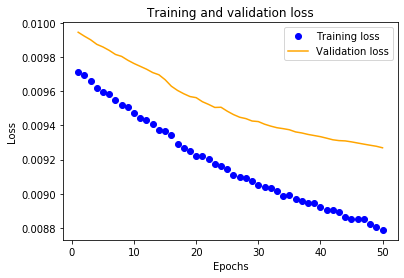

Test loss:  0.008958083242530515


In [21]:
ali.draw_model_history(history)
print("Test loss: ", loss)

#### Save the model

In [ ]:
model.save('markersonly_comparison.h5')
marker_model.save('markersonly_comparison_marker.h5')
encoder_model.save('markersonly_comparison_encoder.h5')

model.save_weights('markersonly_comparison_weights.h5')
marker_model.save_weights('markersonly_comparison_marker_weights.h5')
encoder_model.save_weights('markersonly_comparison_encoder_weights.h5')

# Data analysis

In [22]:
def get_results(cell_types, cell_activations, graph_labels):
    types_list = list(cell_types.items())
    top3s = []
    top3s_act = []
    for cell in cell_activations:
        top3 = cell.argsort()[-3:][::-1]
        top3types = [types_list[i][0] for i in top3]
        top3s.append(top3types)
        
        act = np.zeros((len(cell_activations[0]),))
        for i in top3:
            act[i] = cell[i]
        top3s_act.append(act)

    n = 0
    correct = 0
    for i in range(len(top3s)):
        prediction = top3s[i][0]
        label = graph_labels.iloc[i]

        if str(prediction) == 'nan' or str(label) == 'nan':
            continue

        if prediction == label:
            correct += 1

        elif label in marker_names.keys():
            if marker_names[label] == prediction:
                correct += 1
        n += 1

    print("Correct predictions: {c} out of {n} ({p}%)".format(c=correct, n=n, p=round(100 * (correct/n), 2)))
    print("Dropped {d} cells".format(d=len(cell_activations) - n))
    return top3s_act

In [23]:
cell_activations = marker_model.predict(test_x)
bottleneck_activations = encoder_model.predict(test_x)
graph_labels = test_y

**Mreža pravilno klasificira 82% testnih podatkov (iz baze na kateri se je učila)**

In [24]:
top3 = get_results(cell_types, cell_activations, graph_labels)

NameError: name 'cell_types' is not defined

Spodnji graf prikazuje aktivacije tipov celic. Razvidno je, da izstopa samo en celični tip, ostali tipi pa izrecno manj.

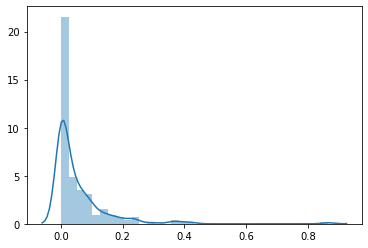

In [25]:
import seaborn as sns
sns.distplot(cell_activations[0])

### New data

In [26]:
new_cell_activations = marker_model.predict(new_data_x)
new_bottleneck_activations = encoder_model.predict(new_data_x)
new_graph_labels = new_labels

NameError: name 'new_data_x' is not defined

**Mreža pravilno klasificira 86% čisto novih podatkov iz druge baze**

In [27]:
new_top3 = get_results(cell_types, new_cell_activations, new_graph_labels)

NameError: name 'cell_types' is not defined

## Graphs

In [ ]:
import random

def get_random_color(pastel_factor = 0.5):
    pastel_factor = random.uniform(0, 1.0)
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

colours = {}
for label in graph_labels.unique():
    colour = (get_random_color())
    colours.update({label:colour})
    
fig = plt.figure()
ax = fig.add_subplot(111)

x = list(range(0, len(colours.values()) * 2, 2))
y = [0]*len(x)
c = list(colours.values())

ax.scatter(x,y,s=400,c=c)
ax.set_title('Plot with Different Marker Color, matplotlib and plotly')

plt.show()

In [ ]:
import pickle

pickle_in = open("Data/Marker_Colours.pickle","rb")
colours = pickle.load(pickle_in)

In [ ]:
pickle_out = open("Data/Marker_Colours.pickle","wb")
pickle.dump(colours, pickle_out)
pickle_out.close()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import OrderedDict
import operator

tnse = TSNE()
pca = PCA()
    
def draw_graph(x, y, model, colours, graph_name=''):
    tsne_out = model.fit_transform(x)
    
    plt.clf()
    plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

    for i, entry in enumerate(tsne_out):
        plt.scatter(entry[0], entry[1], color=colours[y.iloc[i]], label=y.iloc[i])
    
    handles, plt_labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(plt_labels, handles))
    by_label = OrderedDict(sorted(by_label.items()))

    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0., 1, 0, .1))

    plt.title(graph_name)
    plt.axis('off')
    plt.show()

In [ ]:
draw_graph(cell_activations, graph_labels, tnse, colours, graph_name='TSNE of marker activations')

# New Data

In [ ]:
draw_graph(new_cell_activations, new_graph_labels, tnse, colours, graph_name='TSNE of marker activations')

# Combined data

In [ ]:
def draw_comparison(x, y, new_alpha = 1.0, preloaded_tsne=None, title=''):
    if preloaded_tsne is None:
        tsne_out = tnse.fit_transform(x)
    else:
        tsne_out = preloaded_tsne

    plt.clf()
    plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

    for i, entry in enumerate(tsne_out):
        colour = colours[y.iloc[i]]
        alpha = 1.0
        marker = '.'
        if(i <= test_x.shape[0]):
            alpha = new_alpha
            marker = 'x'
        plt.scatter(entry[0], entry[1], color=colour, label=y.iloc[i], alpha=alpha, marker=marker)

    handles, plt_labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(plt_labels, handles))
    by_label = OrderedDict(sorted(by_label.items()))

    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0., 1, 0, .1))

    plt.title(title)
    plt.axis('off')
    plt.show()
    
    #return tsne_out

**Na spodnjem grafu lahko opaziš, da se batch effect še vedno opazi, tudi na aktivacijah markerjev**

In [ ]:
x = test_x.append(new_data_x)
y = test_y.append(new_labels)
compare_cell_activations = encoder_model.predict(x)
tsne_out = draw_comparison(compare_cell_activations, y, new_alpha=0.2, title='Combined TSNE of marker activations')

In [ ]:
draw_comparison(np.vstack((top3, new_top3)), y, new_alpha=0.2, title='Combined TSNE of top 3 activations')

# Reconstruction

**Tukaj sem vzel nove podatke in jih vrgel v avtoenkoder.**

**Nato sem vzel izhodne podatke avtoenkoderja ter vzel njihove aktivacije sloja markerjev.**

**Tako sem dobil nove rezultate, ki so bili konsistentno boljši. V tem primeru za 11%.**

Moja hipoteza je, da se tako delno znebimo batch effecta in zato dobimo boljše rezultate.

In [ ]:
reconstruction = model.predict(new_data_x)
reconstruction = pd.DataFrame(reconstruction, columns=new_data_x.columns)
reconstructed_cell_activations = marker_model.predict(reconstruction)

In [ ]:
draw_graph(reconstructed_cell_activations, new_graph_labels, tnse, colours,
           graph_name='TSNE of reconstructed marker activations')

In [ ]:
_ = get_results(cell_types, reconstructed_cell_activations, new_graph_labels)

Tudi pri teh podatkih batch effect še vedno ostane.

In [ ]:
x = test_x.append(reconstruction)
y = test_y.append(new_labels)
compare_cell_activations = encoder_model.predict(x)
tsne_out = draw_comparison(compare_cell_activations, y, new_alpha=0.2, title='Combined TSNE of marker activations')

# Save the data

In [ ]:
in_data = pd.DataFrame(new_data_x)
out_data = pd.DataFrame(data=model.predict(new_data_x))
in_data.to_pickle('Data/in_data_markersonly.pickle')
out_data.to_pickle('Data/out_data_markersonly.pickle')